<a href="https://colab.research.google.com/github/pushkar-hue/AI-Resume-Parser/blob/main/notebook/rockfall_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print("Loading prepared data arrays...")
X = np.load('X_lstm_ready.npy')
y = np.load('y_lstm_ready.npy')
print(f"Data loaded successfully.")
print("\n--- Data Shapes ---")
print(f"Features (X) shape: {X.shape}")
print(f"Labels (y) shape: {y.shape}")

print("\n--- Shape Explanation ---")
print(f"The features array has 3 dimensions: (Samples, Timesteps, Features)")
print(f"- {X.shape[0]} samples (individual landslide or non-landslide events)")
print(f"- {X.shape[1]} timesteps per sample (representing 10 days of data)")
print(f"- {X.shape[2]} features per timestep (e.g., daily precip, max temp, soil moisture, slope, etc.)")


Loading prepared data arrays...
Data loaded successfully.

--- Data Shapes ---
Features (X) shape: (3266, 10, 14)
Labels (y) shape: (3266,)

--- Shape Explanation ---
The features array has 3 dimensions: (Samples, Timesteps, Features)
- 3266 samples (individual landslide or non-landslide events)
- 10 timesteps per sample (representing 10 days of data)
- 14 features per timestep (e.g., daily precip, max temp, soil moisture, slope, etc.)


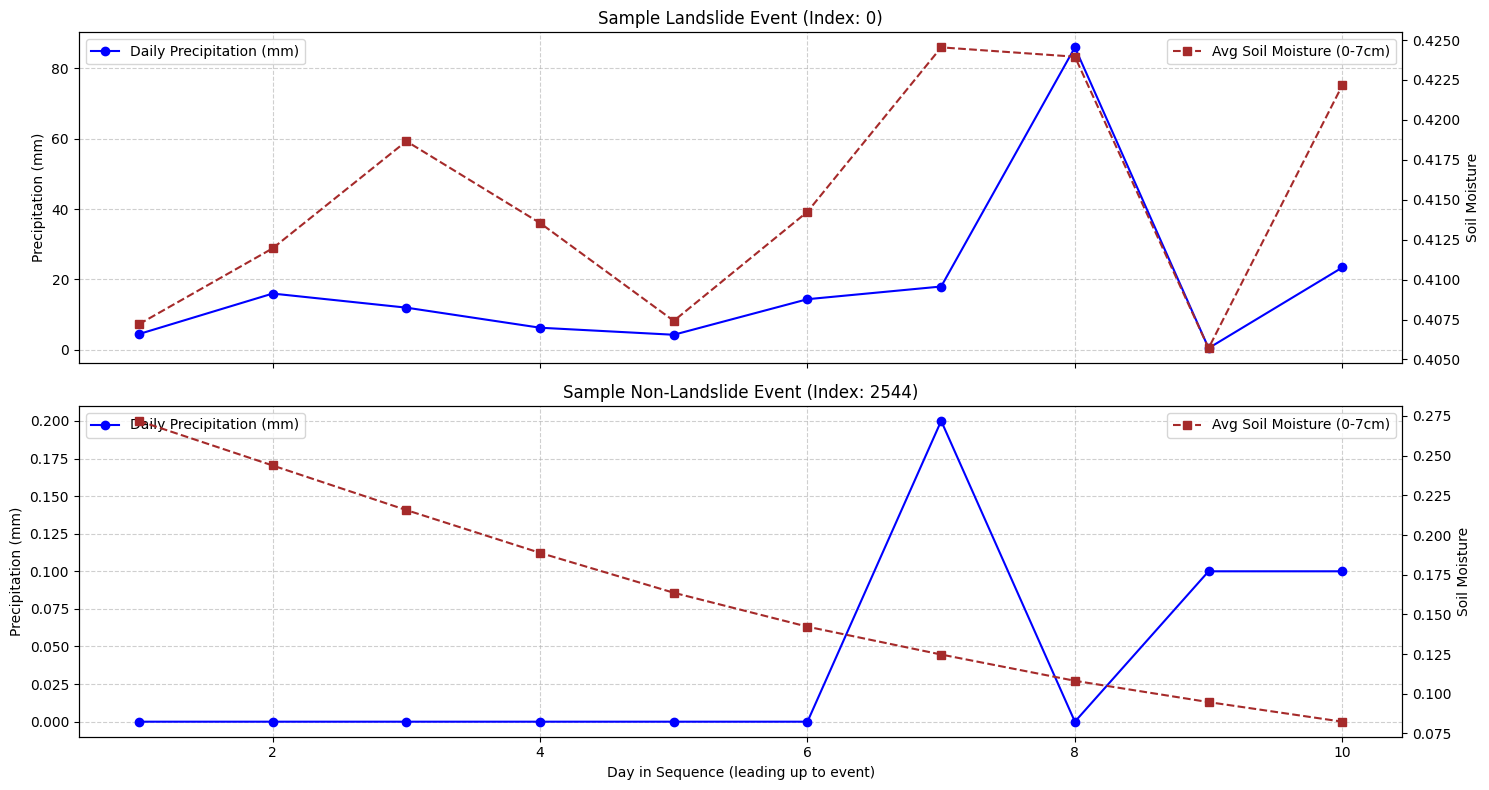

In [ ]:
feature_names = [
    'daily_precip', 'daily_rain', 'daily_snow', 'precip_hours',
    'et0_evapotranspiration', 'max_temp', 'min_temp',
    'avg_soil_moisture_0_7cm', 'avg_soil_moisture_7_28cm',
    'avg_snow_depth', 'avg_relative_humidity', 'elevation', 'slope', 'curvature'
]

# Find the first instance of a landslide (1) and a non-landslide (0) event
landslide_index = np.where(y == 1)[0][0]
non_landslide_index = np.where(y == 0)[0][0]

landslide_sample = X[landslide_index]
non_landslide_sample = X[non_landslide_index]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
days = range(1, 11) # Days 1 to 10

# Plot for Landslide Event
ax1.plot(days, landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title(f'Sample Landslide Event (Index: {landslide_index})')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1_twin = ax1.twinx() # Create a second y-axis
ax1_twin.plot(days, landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax1_twin.set_ylabel('Soil Moisture')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot for Non-Landslide Event
ax2.plot(days, non_landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax2.set_xlabel('Day in Sequence (leading up to event)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title(f'Sample Non-Landslide Event (Index: {non_landslide_index})')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2_twin = ax2.twinx()
ax2_twin.plot(days, non_landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax2_twin.set_ylabel('Soil Moisture')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Calculate class distribution
class_counts = np.bincount(y.astype(int))

# Print the class distribution
print("--- Class Distribution ---")
print(f"Number of non-landslide events (class 0): {class_counts[0]}")
print(f"Number of landslide events (class 1): {class_counts[1]}")

# Optional: Print percentage
total_samples = len(y)
print(f"\nPercentage of non-landslide events: {class_counts[0] / total_samples:.2%}")
print(f"Percentage of landslide events: {class_counts[1] / total_samples:.2%}")

--- Class Distribution ---
Number of non-landslide events (class 0): 722
Number of landslide events (class 1): 2544

Percentage of non-landslide events: 22.11%
Percentage of landslide events: 77.89%


In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(['No Landslide (0)', 'Landslide (1)'], [class_0_count, class_1_count], color=['skyblue', 'salmon'])
plt.title('Distribution of Classes in the Dataset')
plt.ylabel('Number of Samples')
plt.show()

NameError: name 'class_0_count' is not defined

<Figure size 600x400 with 0 Axes>

#  Landslide Prediction with PyTorch LSTM
# This notebook adapts the TensorFlow/Keras model to PyTorch for training in Google Colab.
#
# **Workflow:**
# 1.  Import libraries and set up the GPU device.
# 2.  **Analyze the prepared time-series data.**
# 3.  Define a custom PyTorch `Dataset` for our data.
# 4.  Define the LSTM model architecture using `nn.Module`.
# 5.  Load, scale, and prepare the data using PyTorch `DataLoaders`.
# 6.  Set up the training loop, loss function, and optimizer.
# 7.  Train the model and plot the performance history.
# 8.  Evaluate the final model on the test set.


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## 2. Exploratory Data Analysis (EDA) of Time-Series Data
# Before building the model, let's load our prepared `.npy` files and analyze their structure, check for class balance, and visualize some sample sequences.


In [ ]:

try:
    print("Loading prepared data arrays...")
    X = np.load('X_lstm_full.npy')
    y = np.load('y_lstm_full.npy')
    print(f"Data loaded successfully.")
    print("\n--- Data Shapes ---")
    print(f"Features (X) shape: {X.shape}")
    print(f"Labels (y) shape: {y.shape}")

    print("\n--- Shape Explanation ---")
    print(f"The features array has 3 dimensions: (Samples, Timesteps, Features)")
    print(f"- {X.shape[0]} samples (individual landslide or non-landslide events)")
    print(f"- {X.shape[1]} timesteps per sample (representing 10 days of data)")
    print(f"- {X.shape[2]} features per timestep (e.g., daily precip, max temp, soil moisture, slope, etc.)")

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Data files not found. Make sure you have uploaded 'X_lstm_full.npy' and 'y_lstm_full.npy' to this Colab session.")



In [ ]:

print("\n--- Class Distribution ---")
unique_classes, counts = np.unique(y, return_counts=True)
class_0_count = counts[np.where(unique_classes == 0)][0]
class_1_count = counts[np.where(unique_classes == 1)][0]
total_count = len(y)

print(f"Class 0 (No Landslide): {class_0_count} samples ({class_0_count/total_count:.2%})")
print(f"Class 1 (Landslide): {class_1_count} samples ({class_1_count/total_count:.2%})")


# Plotting the distribution
plt.figure(figsize=(6, 4))
plt.bar(['No Landslide (0)', 'Landslide (1)'], [class_0_count, class_1_count], color=['skyblue', 'salmon'])
plt.title('Distribution of Classes in the Dataset')
plt.ylabel('Number of Samples')
plt.show()



In [ ]:

feature_names = [
    'daily_precip', 'daily_rain', 'daily_snow', 'precip_hours',
    'et0_evapotranspiration', 'max_temp', 'min_temp',
    'avg_soil_moisture_0_7cm', 'avg_soil_moisture_7_28cm',
    'avg_snow_depth', 'avg_relative_humidity', 'elevation', 'slope', 'curvature'
]

# Find the first instance of a landslide (1) and a non-landslide (0) event
landslide_index = np.where(y == 1)[0][0]
non_landslide_index = np.where(y == 0)[0][0]

landslide_sample = X[landslide_index]
non_landslide_sample = X[non_landslide_index]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
days = range(1, 11) # Days 1 to 10

# Plot for Landslide Event
ax1.plot(days, landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title(f'Sample Landslide Event (Index: {landslide_index})')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1_twin = ax1.twinx() # Create a second y-axis
ax1_twin.plot(days, landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax1_twin.set_ylabel('Soil Moisture')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot for Non-Landslide Event
ax2.plot(days, non_landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax2.set_xlabel('Day in Sequence (leading up to event)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title(f'Sample Non-Landslide Event (Index: {non_landslide_index})')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2_twin = ax2.twinx()
ax2_twin.plot(days, non_landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax2_twin.set_ylabel('Soil Moisture')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()



# ## 3. Model Building and Training
# Now we proceed with defining the model architecture, scaling the data, and training the LSTM.

In [ ]:
e
class LandslideLSTM(nn.Module):
    def __init__(self, input_features, hidden_size1, hidden_size2, dense_size):
        super(LandslideLSTM, self).__init__()

        # First LSTM layer
        self.lstm1 = nn.LSTM(input_features, hidden_size1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(0.3)

        # Second LSTM layer
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(0.3)

        # Dense layers
        self.dense1 = nn.Linear(hidden_size2, dense_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(dense_size, 1)

    def forward(self, x):
        # LSTM 1
        lstm_out1, _ = self.lstm1(x)
        # We apply batch norm to the output of the last time step
        # To apply BatchNorm1d, we need to reshape the output
        out = lstm_out1.permute(0, 2, 1) # (batch, features, timesteps)
        out = self.bn1(out)
        out = out.permute(0, 2, 1) # (batch, timesteps, features)
        out = self.dropout1(out)

        # Second LSTM layer
        lstm_out2, _ = self.lstm2(out)
        out = lstm_out2.permute(0, 2, 1)
        out = self.bn2(out)
        out = out.permute(0, 2, 1)
        out = self.dropout2(out[:, -1, :]) # Take only the last timestep's output for dense layers

        # Dense layers
        out = self.dense1(out)
        out = self.relu(out)

        # Output layer
        out = self.output_layer(out)
        return out


In [ ]:

# %%
# CELL 4: Data Scaling and Dataloader Preparation
# --- Scale the features ---
print("Scaling feature data...")
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape((nsamples * ntimesteps, nfeatures))

scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled_reshaped.reshape((nsamples, ntimesteps, nfeatures))
print("Scaling complete.")

# --- Split into training and testing sets ---
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into training ({x_train.shape[0]} samples) and testing ({x_test.shape[0]} samples).")

# --- Convert to PyTorch Tensors ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# --- Create TensorDatasets and DataLoaders ---
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda
Loading prepared data arrays...

--- ERROR ---
Data files not found. Make sure you have uploaded 'X_lstm_full.npy' and 'y_lstm_full.npy' to this Colab session.

--- Class Distribution ---
Class 0 (No Landslide): 722 samples (22.11%)
Class 1 (Landslide): 2544 samples (77.89%)


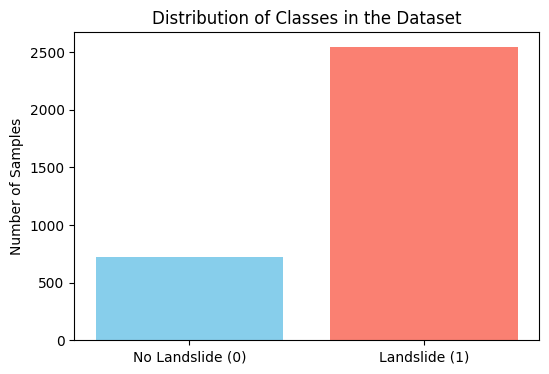

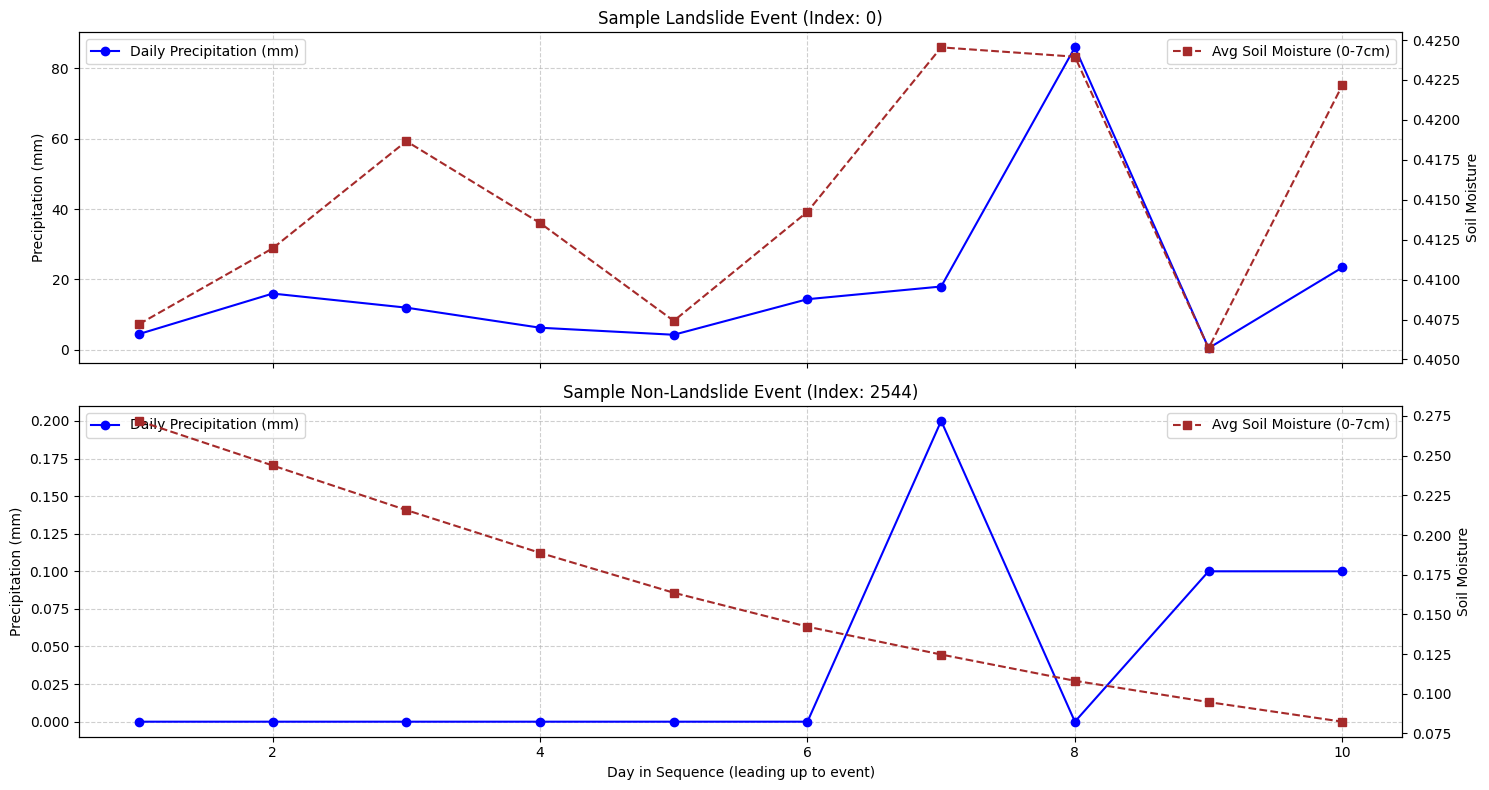

Scaling feature data...
Scaling complete.
Data split into training (2612 samples) and testing (654 samples).
Calculated positive class weight for loss function: 0.2838

Model architecture:
LandslideLSTM(
  (lstm1): LSTM(14, 64, batch_first=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(64, 32, batch_first=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

--- Starting Model Training ---
Epoch [1/30], Loss: 0.2062, Val Loss: 0.1850, Acc: 0.7680, Val Acc: 0.8196
Epoch [2/30], Loss: 0.1692, Val Loss: 0.1730, Acc: 0.8545, Val Acc: 0.8639
Epoch [3/30], Loss: 0.1628, Val Loss: 0.1732, Acc: 0.8553, Val Acc: 0.8425
Epoch [4/30], Loss: 0.1597, Val Loss: 

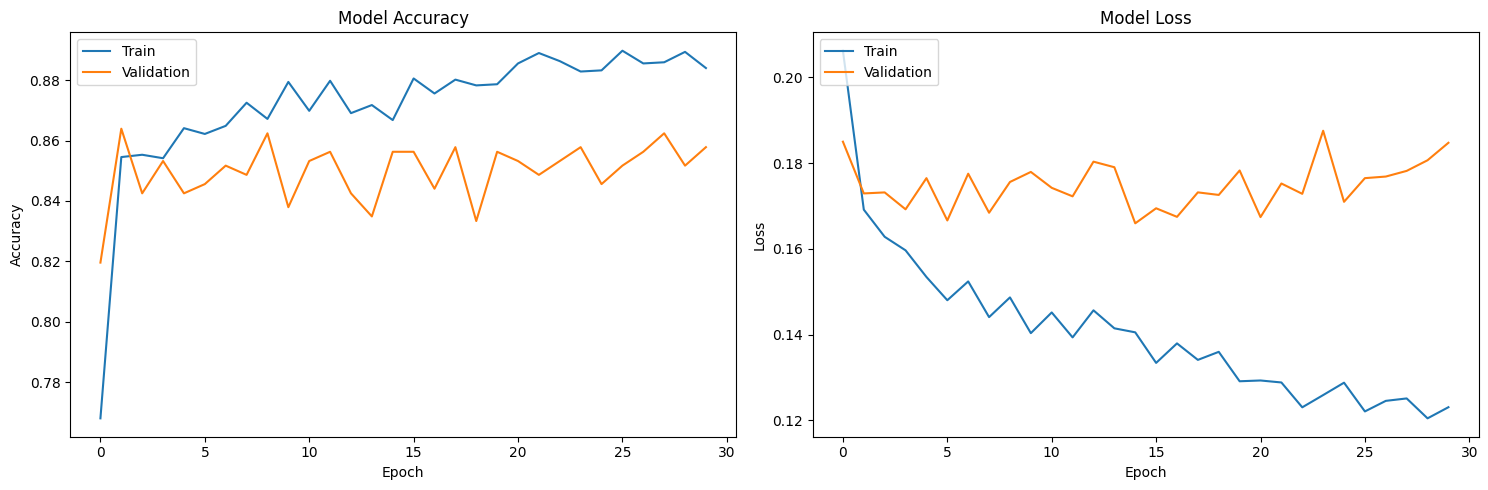


--- Final Model Evaluation ---
Test Accuracy: 0.8578

PyTorch LSTM Classification Report:
              precision    recall  f1-score   support

No Landslide       0.64      0.80      0.71       145
   Landslide       0.94      0.87      0.91       509

    accuracy                           0.86       654
   macro avg       0.79      0.84      0.81       654
weighted avg       0.87      0.86      0.86       654



In [ ]:

# %%
# CELL 5: Model Initialization and Training Setup
# Model parameters
INPUT_FEATURES = x_train_tensor.shape[2]
HIDDEN_SIZE1 = 64
HIDDEN_SIZE2 = 32
DENSE_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 30

# Instantiate the model and move it to the GPU
model = LandslideLSTM(INPUT_FEATURES, HIDDEN_SIZE1, HIDDEN_SIZE2, DENSE_SIZE).to(device)

# --- Loss Function with Class Weighting ---
# Calculate the weight for the positive class (landslide) to handle imbalance.
# pos_weight = num_negative_samples / num_positive_samples
pos_weight_value = class_0_count / class_1_count
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Calculated positive class weight for loss function: {pos_weight_value:.4f}")

# BCEWithLogitsLoss is more numerically stable and takes the weight.
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nModel architecture:")
print(model)

# %%
# CELL 6: Training the Model
print("\n--- Starting Model Training ---")
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == labels).sum().item()

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(test_loader.dataset)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# %%
# CELL 7: Plotting Training History
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# %%
# CELL 8: Final Evaluation on Test Set
print("\n--- Final Model Evaluation ---")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.round(torch.sigmoid(outputs))
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print(f"Test Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nPyTorch LSTM Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['No Landslide', 'Landslide']))



Using device: cuda
Loading prepared data arrays...

--- ERROR ---
Data files not found. Make sure you have uploaded 'X_lstm_full.npy' and 'y_lstm_full.npy' to this Colab session.

--- Class Distribution ---
Class 0 (No Landslide): 722 samples (22.11%)
Class 1 (Landslide): 2544 samples (77.89%)


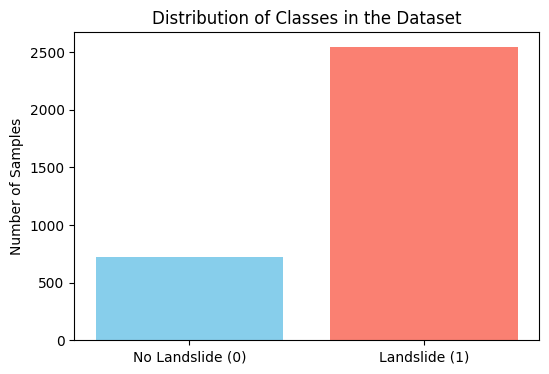

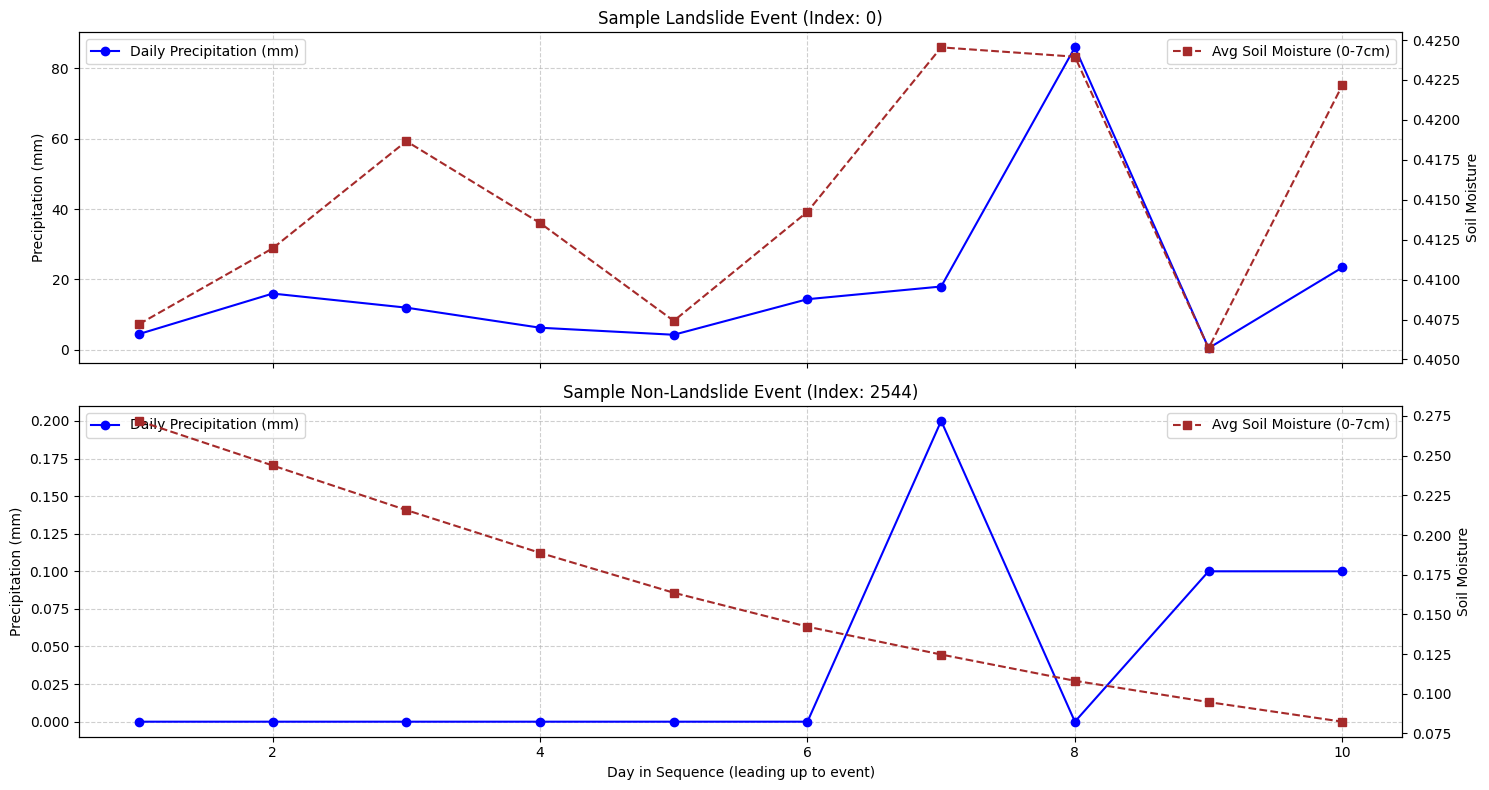

Scaling feature data...
Scaling complete.
Data split into training (2612 samples) and testing (654 samples).
Calculated positive class weight for loss function: 0.2838

Model architecture:
LandslideBiLSTM(
  (lstm1): LSTM(14, 64, batch_first=True, bidirectional=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm2): LSTM(128, 32, batch_first=True, bidirectional=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dense1): Linear(in_features=64, out_features=16, bias=True)
  (relu): ReLU()
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

--- Starting Model Training ---
Epoch [1/30], Loss: 0.2036, Val Loss: 0.1797, Acc: 0.7649, Val Acc: 0.8135
Epoch [2/30], Loss: 0.1640, Val Loss: 0.1729, Acc: 0.8538, Val Acc: 0.8287
Epoch [3/30], Loss: 0.1555, Val Loss: 0.1730, Acc: 0.8534, Val Acc: 0

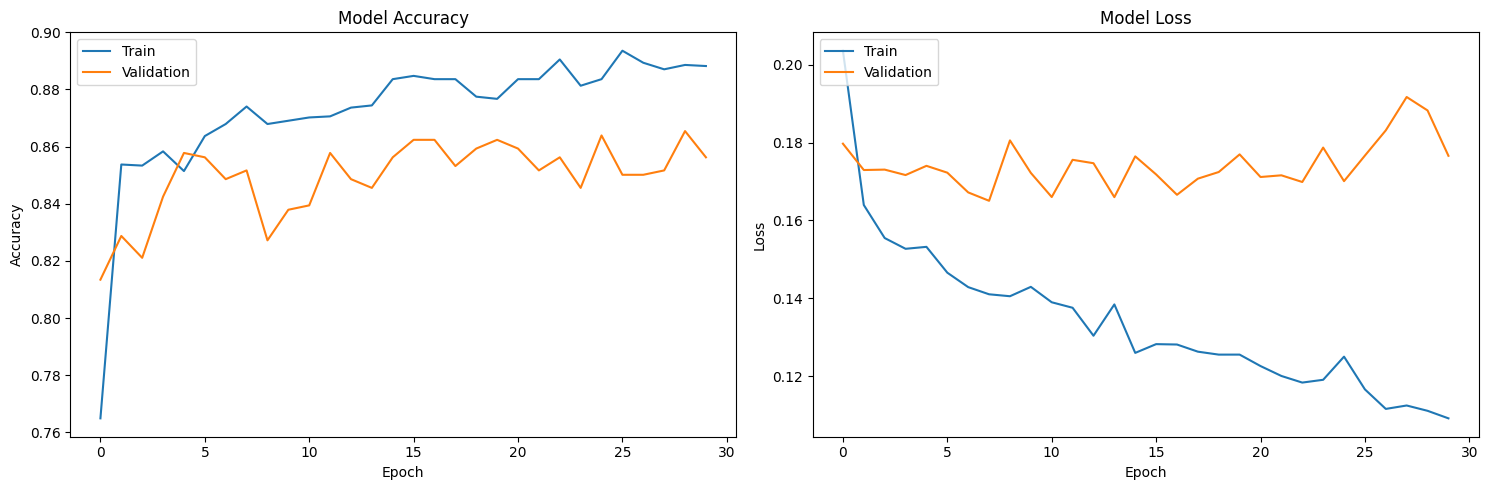


--- Final Model Evaluation ---
Test Accuracy: 0.8563

PyTorch LSTM Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

No Landslide       0.63      0.86      0.73       145
   Landslide       0.96      0.85      0.90       509

    accuracy                           0.86       654
   macro avg       0.79      0.86      0.81       654
weighted avg       0.88      0.86      0.86       654


--- Confusion Matrix ---


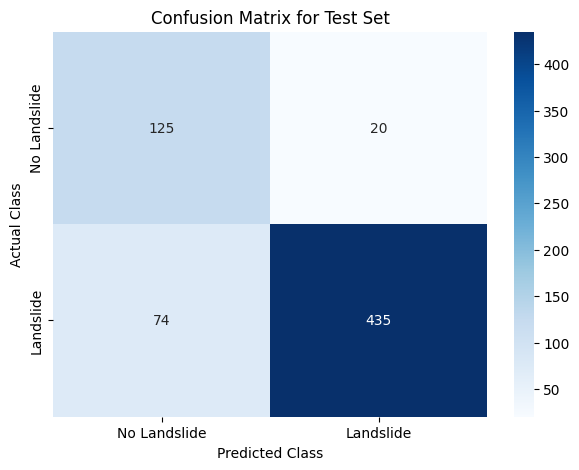


--- ROC Curve & AUC Score ---


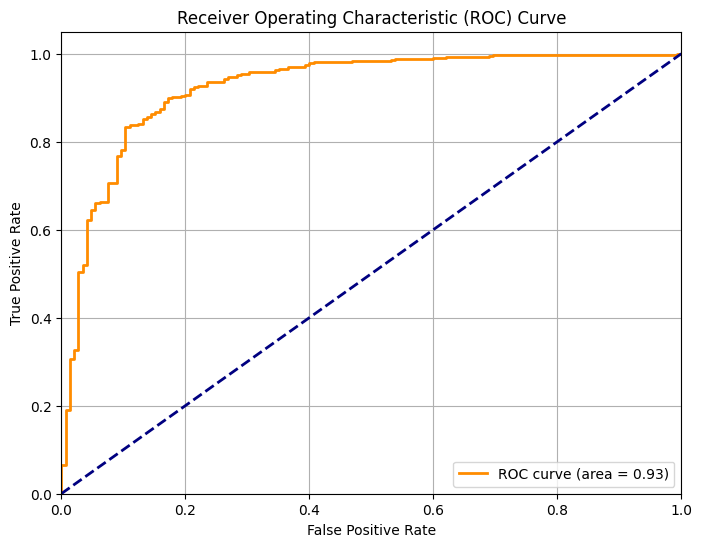

AUC Score: 0.9252

The AUC score represents the model's ability to distinguish between classes. A score of 1.0 is perfect, and 0.5 is no better than random guessing.


In [ ]:
# %% [markdown]
# # Landslide Prediction with PyTorch LSTM
# This notebook adapts the TensorFlow/Keras model to PyTorch for training in Google Colab.
#
# **Workflow:**
# 1.  Import libraries and set up the GPU device.
# 2.  **Analyze the prepared time-series data.**
# 3.  Define a custom PyTorch `Dataset` for our data.
# 4.  Define the **Bidirectional LSTM (BiLSTM)** model architecture.
# 5.  Load, scale, and prepare the data using PyTorch `DataLoaders`.
# 6.  Set up the training loop, loss function, and optimizer.
# 7.  Train the model and plot the performance history.
# 8.  Evaluate the final model on the test set.
# 9.  **Analyze results with a confusion matrix and ROC curve.**

# %%
# CELL 1: Import Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# %%
# CELL 2: Setup Device (GPU/CPU)
# This will use the GPU in Colab if it's available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% [markdown]
# ---
# ## 2. Exploratory Data Analysis (EDA) of Time-Series Data
# Before building the model, let's load our prepared `.npy` files and analyze their structure, check for class balance, and visualize some sample sequences.

# %%
# CELL 2A: Load and Inspect Data Shape
try:
    print("Loading prepared data arrays...")
    X = np.load('X_lstm_full.npy')
    y = np.load('y_lstm_full.npy')
    print(f"Data loaded successfully.")
    print("\n--- Data Shapes ---")
    print(f"Features (X) shape: {X.shape}")
    print(f"Labels (y) shape: {y.shape}")

    print("\n--- Shape Explanation ---")
    print(f"The features array has 3 dimensions: (Samples, Timesteps, Features)")
    print(f"- {X.shape[0]} samples (individual landslide or non-landslide events)")
    print(f"- {X.shape[1]} timesteps per sample (representing 10 days of data)")
    print(f"- {X.shape[2]} features per timestep (e.g., daily precip, max temp, soil moisture, slope, etc.)")

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Data files not found. Make sure you have uploaded 'X_lstm_full.npy' and 'y_lstm_full.npy' to this Colab session.")

# %%
# CELL 2B: Analyze Class Distribution
print("\n--- Class Distribution ---")
unique_classes, counts = np.unique(y, return_counts=True)
class_0_count = counts[np.where(unique_classes == 0)][0]
class_1_count = counts[np.where(unique_classes == 1)][0]
total_count = len(y)

print(f"Class 0 (No Landslide): {class_0_count} samples ({class_0_count/total_count:.2%})")
print(f"Class 1 (Landslide): {class_1_count} samples ({class_1_count/total_count:.2%})")


# Plotting the distribution
plt.figure(figsize=(6, 4))
plt.bar(['No Landslide (0)', 'Landslide (1)'], [class_0_count, class_1_count], color=['skyblue', 'salmon'])
plt.title('Distribution of Classes in the Dataset')
plt.ylabel('Number of Samples')
plt.show()


# %%
# CELL 2C: Visualize Sample Sequences
# This helps understand the patterns the LSTM will learn from.

# Define the feature names in the order they were created in the prep script
feature_names = [
    'daily_precip', 'daily_rain', 'daily_snow', 'precip_hours',
    'et0_evapotranspiration', 'max_temp', 'min_temp',
    'avg_soil_moisture_0_7cm', 'avg_soil_moisture_7_28cm',
    'avg_snow_depth', 'avg_relative_humidity', 'elevation', 'slope', 'curvature'
]

# Find the first instance of a landslide (1) and a non-landslide (0) event
landslide_index = np.where(y == 1)[0][0]
non_landslide_index = np.where(y == 0)[0][0]

landslide_sample = X[landslide_index]
non_landslide_sample = X[non_landslide_index]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
days = range(1, 11) # Days 1 to 10

# Plot for Landslide Event
ax1.plot(days, landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title(f'Sample Landslide Event (Index: {landslide_index})')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1_twin = ax1.twinx() # Create a second y-axis
ax1_twin.plot(days, landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax1_twin.set_ylabel('Soil Moisture')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot for Non-Landslide Event
ax2.plot(days, non_landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax2.set_xlabel('Day in Sequence (leading up to event)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title(f'Sample Non-Landslide Event (Index: {non_landslide_index})')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2_twin = ax2.twinx()
ax2_twin.plot(days, non_landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax2_twin.set_ylabel('Soil Moisture')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()


# %% [markdown]
# ---
# ## 3. Model Building and Training
# Now we proceed with defining the model architecture, scaling the data, and training the model.

# %%
# CELL 3: Define the Bidirectional LSTM Model Architecture
class LandslideBiLSTM(nn.Module):
    def __init__(self, input_features, hidden_size1, hidden_size2, dense_size):
        super(LandslideBiLSTM, self).__init__()

        # First BiLSTM layer
        self.lstm1 = nn.LSTM(input_features, hidden_size1, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1 * 2) # Output features are doubled
        self.dropout1 = nn.Dropout(0.3)

        # Second BiLSTM layer
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2 * 2) # Output features are doubled
        self.dropout2 = nn.Dropout(0.3)

        # Dense layers
        self.dense1 = nn.Linear(hidden_size2 * 2, dense_size) # Input features are doubled
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(dense_size, 1)

    def forward(self, x):
        # BiLSTM 1
        lstm_out1, _ = self.lstm1(x)
        out = lstm_out1.permute(0, 2, 1) # (batch, features, timesteps)
        out = self.bn1(out)
        out = out.permute(0, 2, 1) # (batch, timesteps, features)
        out = self.dropout1(out)

        # BiLSTM 2
        lstm_out2, _ = self.lstm2(out)
        out = lstm_out2.permute(0, 2, 1)
        out = self.bn2(out)
        out = out.permute(0, 2, 1)
        out = self.dropout2(out[:, -1, :]) # Take only the last timestep's output

        # Dense layers
        out = self.dense1(out)
        out = self.relu(out)

        # Output layer
        out = self.output_layer(out)
        return out

# %%
# CELL 4: Data Scaling and Dataloader Preparation
# --- Scale the features ---
print("Scaling feature data...")
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape((nsamples * ntimesteps, nfeatures))

scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled_reshaped.reshape((nsamples, ntimesteps, nfeatures))
print("Scaling complete.")

# --- Split into training and testing sets ---
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into training ({x_train.shape[0]} samples) and testing ({x_test.shape[0]} samples).")

# --- Convert to PyTorch Tensors ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# --- Create TensorDatasets and DataLoaders ---
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# %%
# CELL 5: Model Initialization and Training Setup
# Model parameters
INPUT_FEATURES = x_train_tensor.shape[2]
HIDDEN_SIZE1 = 64
HIDDEN_SIZE2 = 32
DENSE_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 30

# Instantiate the BiLSTM model and move it to the GPU
model = LandslideBiLSTM(INPUT_FEATURES, HIDDEN_SIZE1, HIDDEN_SIZE2, DENSE_SIZE).to(device)

# --- Loss Function with Class Weighting ---
# Calculate the weight for the positive class (landslide) to handle imbalance.
# pos_weight = num_negative_samples / num_positive_samples
pos_weight_value = class_0_count / class_1_count
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Calculated positive class weight for loss function: {pos_weight_value:.4f}")

# BCEWithLogitsLoss is more numerically stable and takes the weight.
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nModel architecture:")
print(model)

# %%
# CELL 6: Training the Model
print("\n--- Starting Model Training ---")
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == labels).sum().item()

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(test_loader.dataset)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# %%
# CELL 7: Plotting Training History
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# %%
# CELL 8: Final Evaluation on Test Set
print("\n--- Final Model Evaluation ---")
model.eval()
all_preds = []
all_labels = []
all_probs = [] # To store probabilities for ROC curve

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get probabilities for ROC curve
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())

        # Get class predictions for classification report
        preds = torch.round(probs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


print(f"Test Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nPyTorch LSTM Classification Report (Threshold = 0.5):")
print(classification_report(all_labels, all_preds, target_names=['No Landslide', 'Landslide']))

# %% [markdown]
# ---
# ## 4. Model Analysis & Improvement
# Let's visualize the model's performance to better understand its strengths and weaknesses.

# %%
# CELL 9: Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# %%
# CELL 10: ROC Curve and AUC Score
print("\n--- ROC Curve & AUC Score ---")
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {auc_score:.4f}")
print("\nThe AUC score represents the model's ability to distinguish between classes. A score of 1.0 is perfect, and 0.5 is no better than random guessing.")



## Landslide Prediction with PyTorch LSTM
 This notebook adapts the TensorFlow/Keras model to PyTorch for training in Google Colab.

## **Workflow:**
1.  Import libraries and set up the GPU device.
2.  **Analyze the prepared time-series data.**
3.  Define a custom PyTorch `Dataset` for our data.
4.  Define the **Bidirectional LSTM (BiLSTM)** model architecture.
5.  Load, scale, and prepare the data using PyTorch `DataLoaders`.
6.  Set up the training loop, loss function, and optimizer.
7.  Train the model and plot the performance history.
8.  Evaluate the final model on the test set.
9.  **Analyze results with a confusion matrix and ROC curve.**
10. **Find and apply the optimal classification threshold.**


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:

try:
    print("Loading prepared data arrays...")
    X = np.load('X_lstm_full.npy')
    y = np.load('y_lstm_full.npy')
    print(f"Data loaded successfully.")
    print("\n--- Data Shapes ---")
    print(f"Features (X) shape: {X.shape}")
    print(f"Labels (y) shape: {y.shape}")

    print("\n--- Shape Explanation ---")
    print(f"The features array has 3 dimensions: (Samples, Timesteps, Features)")
    print(f"- {X.shape[0]} samples (individual landslide or non-landslide events)")
    print(f"- {X.shape[1]} timesteps per sample (representing 10 days of data)")
    print(f"- {X.shape[2]} features per timestep (e.g., daily precip, max temp, soil moisture, slope, etc.)")

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("Data files not found. Make sure you have uploaded 'X_lstm_full.npy' and 'y_lstm_full.npy' to this Colab session.")


In [ ]:
print("\n--- Class Distribution ---")
unique_classes, counts = np.unique(y, return_counts=True)
class_0_count = counts[np.where(unique_classes == 0)][0]
class_1_count = counts[np.where(unique_classes == 1)][0]
total_count = len(y)

print(f"Class 0 (No Landslide): {class_0_count} samples ({class_0_count/total_count:.2%})")
print(f"Class 1 (Landslide): {class_1_count} samples ({class_1_count/total_count:.2%})")


# Plotting the distribution
plt.figure(figsize=(6, 4))
plt.bar(['No Landslide (0)', 'Landslide (1)'], [class_0_count, class_1_count], color=['skyblue', 'salmon'])
plt.title('Distribution of Classes in the Dataset')
plt.ylabel('Number of Samples')
plt.show()



In [ ]:

feature_names = [
    'daily_precip', 'daily_rain', 'daily_snow', 'precip_hours',
    'et0_evapotranspiration', 'max_temp', 'min_temp',
    'avg_soil_moisture_0_7cm', 'avg_soil_moisture_7_28cm',
    'avg_snow_depth', 'avg_relative_humidity', 'elevation', 'slope', 'curvature'
]

# Find the first instance of a landslide (1) and a non-landslide (0) event
landslide_index = np.where(y == 1)[0][0]
non_landslide_index = np.where(y == 0)[0][0]

landslide_sample = X[landslide_index]
non_landslide_sample = X[non_landslide_index]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
days = range(1, 11) # Days 1 to 10

# Plot for Landslide Event
ax1.plot(days, landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax1.set_ylabel('Precipitation (mm)')
ax1.set_title(f'Sample Landslide Event (Index: {landslide_index})')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1_twin = ax1.twinx() # Create a second y-axis
ax1_twin.plot(days, landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax1_twin.set_ylabel('Soil Moisture')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Plot for Non-Landslide Event
ax2.plot(days, non_landslide_sample[:, feature_names.index('daily_precip')], 'o-', label='Daily Precipitation (mm)', color='blue')
ax2.set_xlabel('Day in Sequence (leading up to event)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_title(f'Sample Non-Landslide Event (Index: {non_landslide_index})')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2_twin = ax2.twinx()
ax2_twin.plot(days, non_landslide_sample[:, feature_names.index('avg_soil_moisture_0_7cm')], 's--', label='Avg Soil Moisture (0-7cm)', color='brown')
ax2_twin.set_ylabel('Soil Moisture')
ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')

plt.tight_layout()
plt.show()



In [ ]:
class LandslideBiLSTM(nn.Module):
    def __init__(self, input_features, hidden_size1, hidden_size2, dense_size):
        super(LandslideBiLSTM, self).__init__()

        # First BiLSTM layer
        self.lstm1 = nn.LSTM(input_features, hidden_size1, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(hidden_size1 * 2) # Output features are doubled
        self.dropout1 = nn.Dropout(0.3)

        # Second BiLSTM layer
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(hidden_size2 * 2) # Output features are doubled
        self.dropout2 = nn.Dropout(0.3)

        # Dense layers
        self.dense1 = nn.Linear(hidden_size2 * 2, dense_size) # Input features are doubled
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(dense_size, 1)

    def forward(self, x):
        # BiLSTM 1
        lstm_out1, _ = self.lstm1(x)
        out = lstm_out1.permute(0, 2, 1) # (batch, features, timesteps)
        out = self.bn1(out)
        out = out.permute(0, 2, 1) # (batch, timesteps, features)
        out = self.dropout1(out)

        # BiLSTM 2
        lstm_out2, _ = self.lstm2(out)
        out = lstm_out2.permute(0, 2, 1)
        out = self.bn2(out)
        out = out.permute(0, 2, 1)
        out = self.dropout2(out[:, -1, :]) # Take only the last timestep's output

        # Dense layers
        out = self.dense1(out)
        out = self.relu(out)

        # Output layer
        out = self.output_layer(out)
        return out


In [ ]:
print("Scaling feature data...")
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape((nsamples * ntimesteps, nfeatures))

scaler = StandardScaler()
X_scaled_reshaped = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled_reshaped.reshape((nsamples, ntimesteps, nfeatures))
print("Scaling complete.")

# --- Split into training and testing sets ---
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Data split into training ({x_train.shape[0]} samples) and testing ({x_test.shape[0]} samples).")

# --- Convert to PyTorch Tensors ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# --- Create TensorDatasets and DataLoaders ---
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:

INPUT_FEATURES = x_train_tensor.shape[2]
HIDDEN_SIZE1 = 64
HIDDEN_SIZE2 = 32
DENSE_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 30

# Instantiate the BiLSTM model and move it to the GPU
model = LandslideBiLSTM(INPUT_FEATURES, HIDDEN_SIZE1, HIDDEN_SIZE2, DENSE_SIZE).to(device)

# --- Loss Function with Class Weighting ---
# Calculate the weight for the positive class (landslide) to handle imbalance.
# pos_weight = num_negative_samples / num_positive_samples
pos_weight_value = class_0_count / class_1_count
pos_weight_tensor = torch.tensor([pos_weight_value], dtype=torch.float32).to(device)
print(f"Calculated positive class weight for loss function: {pos_weight_value:.4f}")

# BCEWithLogitsLoss is more numerically stable and takes the weight.
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("\nModel architecture:")
print(model)


In [ ]:
print("\n--- Starting Model Training ---")
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

for epoch in range(EPOCHS):
    model.train()  # Set model to training mode
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = torch.round(torch.sigmoid(outputs))
        train_correct += (preds == labels).sum().item()

    # --- Validation ---
    model.eval()  # Set model to evaluation mode
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.round(torch.sigmoid(outputs))
            val_correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_acc = train_correct / len(train_loader.dataset)
    val_acc = val_correct / len(test_loader.dataset)

    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')


In [ ]:
print("\n--- Plotting Training History ---")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training & validation accuracy values
ax1.plot(history['accuracy'])
ax1.plot(history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history['loss'])
ax2.plot(history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
print("\n--- Final Model Evaluation ---")
model.eval()
all_preds = []
all_labels = []
all_probs = [] # To store probabilities for ROC curve

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Get probabilities for ROC curve
        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())

        # Get class predictions for classification report
        preds = torch.round(probs)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


print(f"Test Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
print("\nPyTorch LSTM Classification Report (Threshold = 0.5):")
print(classification_report(all_labels, all_preds, target_names=['No Landslide', 'Landslide']))


In [ ]:

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
print("\n--- ROC Curve & AUC Score ---")
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {auc_score:.4f}")
print("\nThe AUC score represents the model's ability to distinguish between classes. A score of 1.0 is perfect, and 0.5 is no better than random guessing.")


## Final Model Tuning & Interpretation
 An AUC of 0.93 is excellent. Now we can fine-tune our classification threshold to find the best balance between catching landslides (recall) and avoiding false alarms (precision).


In [ ]:
# The optimal threshold is the one that maximizes (True Positive Rate - False Positive Rate)
# This is also known as Youden's J statistic.
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold found at: {optimal_threshold:.4f}")
print("This threshold provides the best balance between sensitivity and specificity.")


In [ ]:

print(f"\n--- Re-evaluating with new threshold of {optimal_threshold:.4f} ---")
y_pred_optimal = (all_probs > optimal_threshold).astype("int32")

print(f"Test Accuracy (Optimal Threshold): {accuracy_score(all_labels, y_pred_optimal):.4f}")
print("\nPyTorch BiLSTM Classification Report (Optimal Threshold):")
print(classification_report(all_labels, y_pred_optimal, target_names=['No Landslide', 'Landslide']))


In [ ]:
print("\n--- Confusion Matrix (Optimal Threshold) ---")
cm_optimal = confusion_matrix(all_labels, y_pred_optimal)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Landslide', 'Landslide'],
            yticklabels=['No Landslide', 'Landslide'])
plt.title('Confusion Matrix for Test Set (Optimal Threshold)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


## Conclusion & Next Steps
**Project Summary:**
- We successfully collected and processed a time-series dataset for both landslide and non-landslide events.
- We trained a Bidirectional LSTM model that showed a strong ability to distinguish between the two classes, achieving a high AUC score of 0.93.
- By tuning the classification threshold, we found an optimal balance, significantly improving the recall for the minority "No Landslide" class while maintaining high precision for "Landslide" alerts.
**Path to Dashboard:**
This trained and tuned model is now ready to be the "brain" of your hackathon dashboard. The next steps are:
1.  **Save the Model:** Save the trained PyTorch model (`model.state_dict()`) and the `StandardScaler` object (`scaler`) so you can load them in your dashboard application.
2.  **Create a Prediction Function:** Write a function that takes a new 10-day weather sequence, applies the saved scaler, converts it to a tensor, and feeds it to the loaded model to get a risk probability.
3.  **Build the UI:** Use a tool like Streamlit or Dash to create a user interface that allows a user to select a location, fetches live weather data, and displays the model's risk prediction using the optimal threshold.

